<a href="https://colab.research.google.com/github/A-Peoples/Sports-Player-Analyzed/blob/main/R_Wilson_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**I made an article about this: https://medium.com/@ahlon.aj.peoples/understanding-russell-wilsons-falloff-2c051cc6acff**

**Importing Packages**

In [82]:
!pip install nfl_data_py

import nfl_data_py as nfl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

df = nfl.import_pbp_data(range(2012, 2024))

2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


**Creating Russell Wilson's Stats**

In [83]:
#filtering the data with .loc to include plays that directly involve Russell Wilson

wilson_df = df.loc[(df["passer_player_name"] == "R.Wilson") | (df["rusher_player_name" ]== "R.Wilson")]

#creating a groupby to combine passing or running stats from the seperate rows from different seasons
wilson_passing_stats = wilson_df.groupby(by=['passer_player_name', 'season', "posteam"]).agg({"passing_yards" : "sum", 'sack':"sum", "play_id":"count", "epa":"mean", "interception":"sum", 'week': "unique", "touchdown":"sum"}).reset_index()
wilson_rushing_stats = wilson_df.groupby(by=['rusher_player_name', 'season', "posteam"]).agg({"rushing_yards" : "sum", 'fumble':"sum", "play_id":"count", "epa":"mean", "touchdown":"sum"}).reset_index()


#merging and adjusting the passing and rushing stats
wilson_stats = wilson_rushing_stats.merge(wilson_passing_stats, on=["season", "posteam"])
wilson_stats["total_yards"] = wilson_stats['rushing_yards'] + wilson_stats['passing_yards']
wilson_stats["touchdown"] = wilson_stats['touchdown_x'] + wilson_stats['touchdown_y']
wilson_stats["play_id"] = wilson_rushing_stats['play_id'] + wilson_passing_stats['play_id']
wilson_stats = wilson_stats[["passer_player_name", "season", "posteam", "rushing_yards", "passing_yards", "total_yards", "fumble", "sack", "interception", "play_id", 'touchdown']]
wilson_stats

,passer_player_name,season,posteam,rushing_yards,passing_yards,total_yards,fumble,sack,interception,play_id,touchdown
0,R.Wilson,2012,SEA,616.0,3690.0,4306.0,3.0,40.0,11.0,605,36.0
1,R.Wilson,2013,SEA,581.0,3881.0,4462.0,3.0,51.0,9.0,634,30.0
2,R.Wilson,2014,SEA,935.0,4199.0,5134.0,8.0,52.0,12.0,713,33.0
3,R.Wilson,2015,SEA,606.0,4532.0,5138.0,7.0,52.0,11.0,723,41.0
4,R.Wilson,2016,SEA,305.0,4668.0,4973.0,2.0,47.0,13.0,736,26.0
5,R.Wilson,2017,SEA,586.0,3983.0,4569.0,6.0,43.0,11.0,696,38.0
6,R.Wilson,2018,SEA,390.0,3681.0,4071.0,3.0,52.0,7.0,577,39.0
7,R.Wilson,2019,SEA,451.0,4712.0,5163.0,4.0,54.0,5.0,725,40.0
8,R.Wilson,2020,SEA,563.0,4386.0,4949.0,4.0,52.0,14.0,726,46.0
9,R.Wilson,2021,SEA,183.0,3113.0,3296.0,2.0,33.0,6.0,478,28.0


**Creating Line Graph**

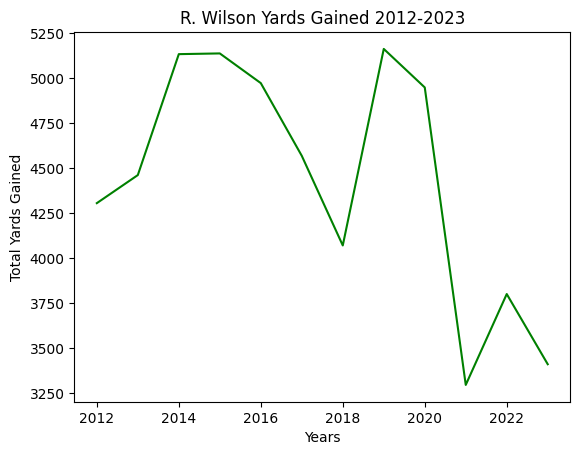

<Figure size 800x800 with 0 Axes>

In [84]:
#using pyplot to create plots
plt.plot(wilson_stats["season"], wilson_stats["total_yards"], c = "g")
plt.title("R. Wilson Yards Gained 2012-2023")
plt.xlabel("Years")
plt.ylabel("Total Yards Gained")
plt.figure(figsize=(8, 8))
plt.show()

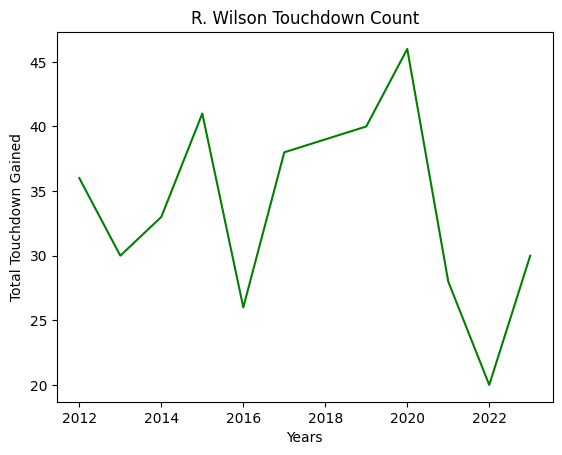

<Figure size 800x800 with 0 Axes>

In [85]:
plt.plot(wilson_stats["season"], wilson_stats["touchdown"], c = "g")
plt.title("R. Wilson Touchdown Count")
plt.xlabel("Years")
plt.ylabel("Total Touchdown Gained")
plt.figure(figsize=(8, 8))
plt.show()

**Creating Wilson's Injury Timeline**

In [86]:
#using the imjury to show Russell Wilson's injuries throughout his career
injures = nfl.import_injuries(range(2012, 2024))
injures = injures.loc[(injures['full_name'] == "Russell Wilson")]
#filtering it to make it look easier
R_Wilson_Injures = injures[["season", "week", "full_name","practice_primary_injury"]]
R_Wilson_Injures = R_Wilson_Injures.loc[R_Wilson_Injures['season'] > 2020]
R_Wilson_Injures

,season,week,full_name,practice_primary_injury
1665,2021.0,6.0,Russell Wilson,right Finger
3112,2021.0,11.0,Russell Wilson,right Finger
4663,2021.0,16.0,Russell Wilson,Ankle
1124,2022.0,5.0,Russell Wilson,right Shoulder
1469,2022.0,6.0,Russell Wilson,right Shoulder
1785,2022.0,7.0,Russell Wilson,Hamstring
2095,2022.0,8.0,Russell Wilson,Hamstring
4215,2022.0,15.0,Russell Wilson,Concussion


In [87]:
epa_df = df.groupby(by=["posteam", "season"]).agg({ "epa":"mean"}).reset_index()
epa_df = epa_df.loc[epa_df["season"] == 2023]
epa_df = epa_df.sort_values(by="epa", ascending=False)
epa_df["rank"] = range(1, len(epa_df) + 1)

epa_df

,posteam,season,epa,rank
347,SF,2023,0.117767,1
107,DAL,2023,0.090758,2
47,BUF,2023,0.062884,3
239,MIA,2023,0.055729,4
143,GB,2023,0.047714,5
35,BAL,2023,0.047380,6
311,PHI,2023,0.043068,7
131,DET,2023,0.033001,8
335,SEA,2023,0.015927,9
191,KC,2023,0.014037,10
